In [106]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as spio
from scipy.stats import norm 
from scipy.stats import multivariate_normal
import time
import sys
import cv2
flt_min = sys.float_info.min

%matplotlib inline

In [107]:
import glob
import numpy as np
import matplotlib.pyplot as plt

def readimgs(Apple_path,Mask_path):
    #Read the image and normalize it,change the mask image to only 0 and 1 image.

    files = glob.glob(Apple_path)
    AppleImgs = []
    for myFile in files:
        im = plt.imread(myFile)
        im = im/255.0
        AppleImgs.append(np.array(im))

    files = glob.glob(Mask_path)
    MaskImgs = []
    for myFile in files:
        im = plt.imread(myFile)
        im = im[:, :, 0]
        im = (im > 0).astype(np.uint8)
        MaskImgs.append(np.array(im))
    return AppleImgs, MaskImgs

In [108]:
import numpy as np

class MyGaussianMixture:
    #the mixture gaussian class

    def __init__(self, n_components=3, epoch    =100, tol=1e-4):
        self.k = n_components
        self.epoch = epoch
        self.tol = tol
        self.means = None
        self.cov = None
        self.weights = None

    def fit(self, X):
        # reuse the codes before in A B C

        nDims,nData = X.shape
        self.weights = (1 / self.k) * np.ones(shape=(self.k))    
        #random_mum = np.random.choice(n_samples, self.n_components,replace=False)
        self.means = 2 * np.random.randn(nDims, self.k)

        self.cov = np.zeros(shape=(nDims, nDims, self.k))
        for cGauss in range(self.k):
            self.cov[:, :, cGauss] = 2.5 + 1.5 * np.random.uniform() * np.eye(nDims)
        
        responsibilities = np.zeros((self.k,nData))
        for iter in range(self.epoch):
            # E-step
            for cData in range(nData):           
                thisData=X[:,cData]
        
                for ig in range(self.k):
                    poss=self.calcGaussianProb(thisData,self.means[...,ig],self.cov[...,ig])
                    # print(poss)
                    responsibilities[ig,cData]=self.weights[ig] * poss 
            
                responsibilities_sum = np.sum(responsibilities[:,cData])
                responsibilities[:,cData] /= responsibilities_sum

            # ===================== =====================                                                                
            # Maximization Step                                                                                          
            # ===================== =====================                                                                                                                                        
            for cGauss in range(self.k):                                                                                      
                # TO DO:  Update weighting parameters mixGauss.weight based on the total    
                sum1= np.sum(responsibilities[cGauss,:])      
                sum3= np.sum(responsibilities[cGauss,:]*X,axis=1)
                # posterior probability associated with each Gaussian. Replace this:                                         
                self.weights[cGauss] = sum1 / nData
                                                
                self.means[:,cGauss] = sum3/sum1
                                           
                weighted_cov=0
                for cdata in range(nData):
                    diff = X[:,cdata] - self.means[:,cGauss]
                    weighted_cov += responsibilities[cGauss,cdata]*np.outer(diff,diff)
                regular = 1e-6 * np.eye(nDims)
                self.cov[:,:,cGauss] =  weighted_cov / (sum1 +regular) 

            
            # Nk = responsibilities.sum(axis=0)
            # self.weights = Nk / nData
            # self.means = np.dot(responsibilities.T, X) / Nk[:, np.newaxis]
            # for k in range(self.n_components):
            #     diff = X - self.means[k]
            #     self.cov[k] = np.dot(responsibilities[:, k] * diff.T, diff) / Nk[k]
            logLike = self.getMixGaussLogLike(X)  

            print("iter:",iter,"  log_likelihood:",logLike)

    def getMixGaussLogLike(self,data):
        #caculate the loglike. Print out during fitting,just to make sure the fit process goes reasonably.

        data = np.atleast_2d(data)                                                                                                                                 
        nDims, nData = data.shape                                                                                                                      
        Like = 0

        curWeight=self.weights
        curMean=self.means
        curCov=self.cov                                                                  
        for cData in range(nData):                                                                         
            thisData = data[:, cData]    

            # TO DO (e) - calculate likelihood of this data point under mixture of                         
            # Gaussians model. Replace this 
            like = 0
            for ig in range(self.k):    
                like+=curWeight[ig]*self.calcGaussianProb(thisData,curMean[...,ig],curCov[...,ig])                                                     
                                                                                                        
            # add to total log like                                                                        
            Like+=np.log(like)                                                               
                                                                                                        
        return  np.array(Like).item()   
    
    def getMixGaussLike(self,data):
        #here is the calculation of likelihood. Return each pixels' likelihood. 

        data = np.atleast_2d(data)                                                                                                                                 
        nDims, nData = data.shape                                                                                                                      
        Like = []

        curWeight=self.weights
        curMean=self.means
        curCov=self.cov                                                                  
        for cData in range(nData):                                                                         
            thisData = data[:, cData]    

            # TO DO (e) - calculate likelihood of this data point under mixture of                         
            # Gaussians model. Replace this 
            like = 0
            for ig in range(self.k):    
                like+=curWeight[ig]*self.calcGaussianProb(thisData,curMean[...,ig],curCov[...,ig])                                                     
                                                                                                        
            # add to total log like                                                                        
            Like.append(like)                                                               
                                                                                                        
        return  np.array(Like)

    def calcGaussianProb(self,data,gaussMean,gaussCov):
       
        #epsilon = 1e-6  # Small value to ensure positive definiteness
        #gaussCov += epsilon * np.eye(gaussCov.shape[0])
        nDim = data.shape[0]
        diff = data-gaussMean
        like=1.0/((2.0*np.pi)**(nDim/2.0)*np.linalg.det(gaussCov)**0.5)*np.exp(-0.5*diff.T@np.linalg.inv(gaussCov)@diff)
    
        return like                                                                             


In [109]:
def posterior(testImage,apple,noapple,apple_pixels,noapple_pixels):
    #calculation of posterior,first get the likelihoods of a pixel(both apple and noneapple likelihood)
    #then calculate the posterior.
    #the prior here is calculate by the number of apple and noneapple pixels.
    
    priorApples = len(apple_pixels[1]) / (len(apple_pixels[1]) + len(noapple_pixels[1]))
    priorNonApples = 1 - priorApples
    print(priorApples)
    print(priorNonApples)
    posteriorApples = []

    for img in testImage:

        # img = plt.imread(picture)
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        X = img.reshape(-1, img.shape[2])
        X = X.T
        likeApples = apple.getMixGaussLike(X)
        likeNonApples = noapple.getMixGaussLike(X)
        print(np.max(likeApples))
        print(np.max(likeNonApples))
        posterior = (likeApples * priorApples) / (likeApples * priorApples + likeNonApples * priorNonApples)
        posterior = np.array(posterior)
        posteriorApples.append(posterior)

    return posteriorApples


In [110]:
import numpy as np
import matplotlib.pyplot as plt

def preparation(Apple_path,Mask_path):
    # read the images and change the pixels into shape of [nDimensions,nData]

    AppleImgs,MaskImgs = readimgs(Apple_path,Mask_path)
    apple_pixels=[]
    noapple_pixels = []
    for apples,masks in zip(AppleImgs,MaskImgs):
        apple_p = apples[masks == 1.]
        noapple_p = apples[masks == 0.]
        apple_pixels.append(apple_p)
        noapple_pixels.append(noapple_p)

    apple_pixels = np.vstack(apple_pixels).T
    noapple_pixels = np.vstack(noapple_pixels).T
    apple_pixels = np.array(apple_pixels)
    noapple_pixels = np.array(noapple_pixels)

    return AppleImgs,MaskImgs,apple_pixels,noapple_pixels

In [111]:
def fit_gussan(num_components,apple_pixels,noapple_pixels):
    # training part,the number of components is 3,and number of epoch is 30.
    # The loglikelihood printed while training showed that 30 epochs can get a quite good result.

    gmm = MyGaussianMixture(n_components=num_components, epoch=30)
    gmmno = MyGaussianMixture(n_components=num_components, epoch=30)
    gmm.fit(apple_pixels)
    gmmno.fit(noapple_pixels)
    return gmm,gmmno


In [134]:
def posterior_show(AppleImgs,MaskImgs,gmm,gmmno,apple_pixels,noapple_pixels):
    
    pos_list = posterior(AppleImgs,gmm,gmmno,apple_pixels,noapple_pixels)

    for i, posteri in enumerate(pos_list):
        im_shape = AppleImgs[i].shape[:2]
        posterior_image = posteri.reshape(im_shape)
        
        plt.figure(figsize=(10, 5))
        
        plt.subplot(1, 3, 1)
        plt.imshow(AppleImgs[i])
        plt.subplot(1, 3, 2)
        plt.imshow(posterior_image, cmap="gray")
        if len(MaskImgs)>i:
            plt.subplot(1, 3, 3)
            plt.imshow(MaskImgs[i], cmap="gray")
        
        plt.show()
    return pos_list

In [113]:

#used to change the channels of img cause the picture i found got a visibility channel


# import cv2
# Apple_path = "myApples/*.png"
# Mask_path = "myApples/*.jpg"
# files = glob.glob(Apple_path)
# AppleImgs = []
# for myFile in files:
#     im = plt.imread(myFile)
#     im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
#     AppleImgs.append(im[:,:,:3])

# files = glob.glob(Mask_path)
# MaskImgs = []
# for myFile in files:
#     im = plt.imread(myFile)
#     im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
#     MaskImgs.append(im[:,:,:3])

# print(MaskImgs[1].shape)
# print(AppleImgs[1].shape)

# plt.imshow(MaskImgs[1])
# plt.axis("off")
# plt.show()

# cv2.imwrite("myApples/mask1.jpg", MaskImgs[0]*255)
# cv2.imwrite("myApples/mask2.jpg", MaskImgs[1]*255)

# cv2.imwrite("myApples/apples1.png", AppleImgs[0]*255)
# cv2.imwrite("myApples/apples2.png", AppleImgs[1]*255)

'\nused to change the channels of img cause the picture i found got a visibility channel\n'

In [ ]:
Apple_path = "apples/apples/*.jpg"
Mask_path = "apples/apples/*.png"
# testAppleImgs, testMaskImgs = readimgs(Apple_path=Apple_path,Mask_path=Mask_path)
# pos_list = []
# Apple_path = "myApples/*.png"
# Mask_path = "myApples/*.jpg"
AppleImgs,MaskImgs,apple_pixels,noapple_pixels = preparation(Apple_path=Apple_path,Mask_path=Mask_path)
gmm,gmmno = fit_gussan(num_components=3,apple_pixels=apple_pixels,noapple_pixels=noapple_pixels)

0.5368561789329002
0.46314382106709984
28.74037093056408
591.3312293239285
28.761606080011838
591.3312293239285
28.727381801772722
591.3312293239285


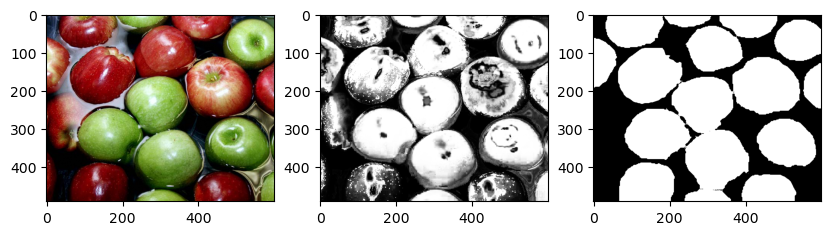

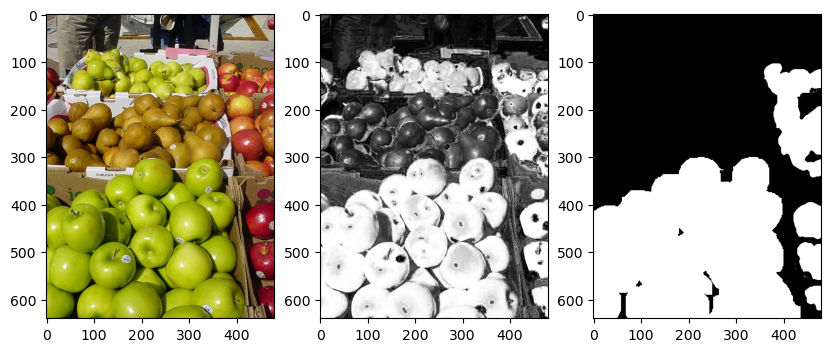

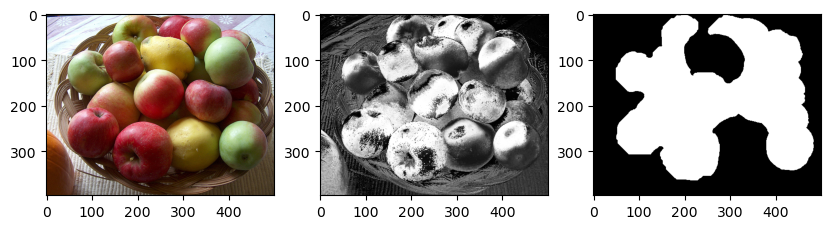

In [120]:
pos_list = posterior_show(AppleImgs,MaskImgs,gmm,gmmno,apple_pixels,noapple_pixels)

In [ ]:
Apple_path = "testApples/*.jpg"
Mask_path = "testApples/*.png"
files = glob.glob(Apple_path)
testAppleImgs = []
for myFile in files:
    im = plt.imread(myFile)
    im = im/255.0
    testAppleImgs.append(np.array(im))
files = glob.glob(Mask_path)
testMaskImgs = []
for myFile in files:
    im = plt.imread(myFile)
    im = im[:, :, 0]
    im = (im > 0).astype(np.uint8)
    testMaskImgs.append(np.array(im))
pos_list = posterior_show(testAppleImgs,testMaskImgs,gmm,gmmno,apple_pixels,noapple_pixels)

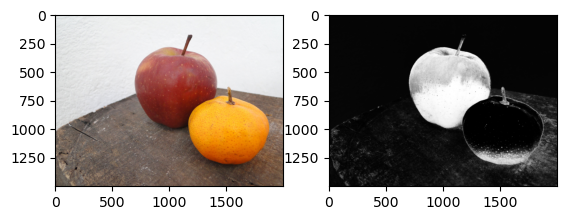

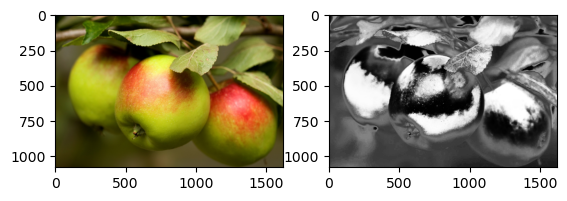

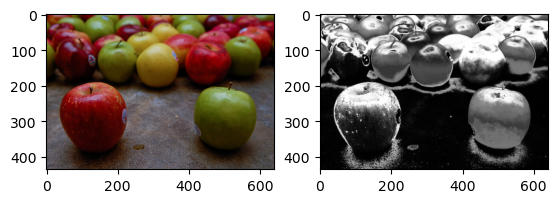

In [54]:
for i, posteri in enumerate(pos_list):
        im_shape = testAppleImgs[i].shape[:2]
        posterior_image = posteri.reshape(im_shape)
        
        plt.figure(figsize=(10, 5))
        
        plt.subplot(1, 3, 1)
        plt.imshow(testAppleImgs[i])
        plt.subplot(1, 3, 2)
        plt.imshow(posterior_image, cmap="gray")
        
        plt.show()

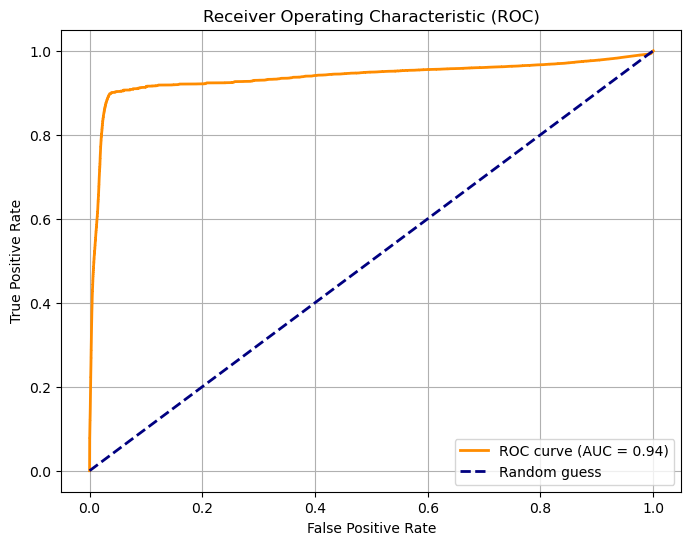

In [128]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(posterior, groundtruth):
    """
    Plot the ROC curve and calculate the AUC
    """
    posterior = posterior.flatten()
    groundtruth = groundtruth.flatten()

    fpr, tpr, thresholds = roc_curve(groundtruth, posterior)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--", label="Random guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC)")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

files = glob.glob("testApples/*.png")
MaskImgs = []
for myFile in files:
    im = plt.imread(myFile)
    im = im[:, :, 0]
    im = (im > 0).astype(np.uint8)
    MaskImgs.append(np.array(im))
plot_roc_curve(pos_list[0],MaskImgs[0])


0.5368561789329002
0.46314382106709984
0.5985754126204774
438.38379869358107
0.5879651661724573
438.38379869358107


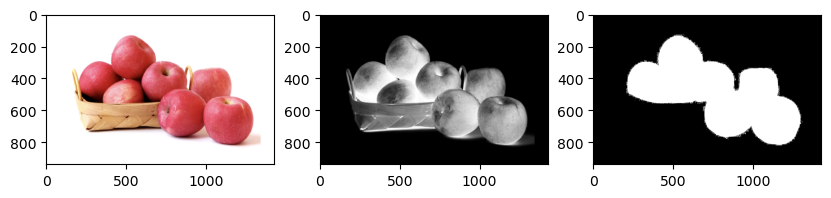

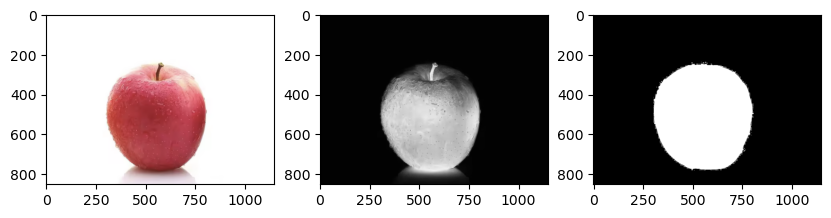

In [135]:
#here are the extra apples I found 

Apple_path = "myApples/*.png"
Mask_path = "myApples/*.jpg"
myAppleImgs,myMaskImgs = readimgs(Apple_path,Mask_path)
pos_list = posterior_show(myAppleImgs,myMaskImgs,gmm,gmmno,apple_pixels,noapple_pixels)

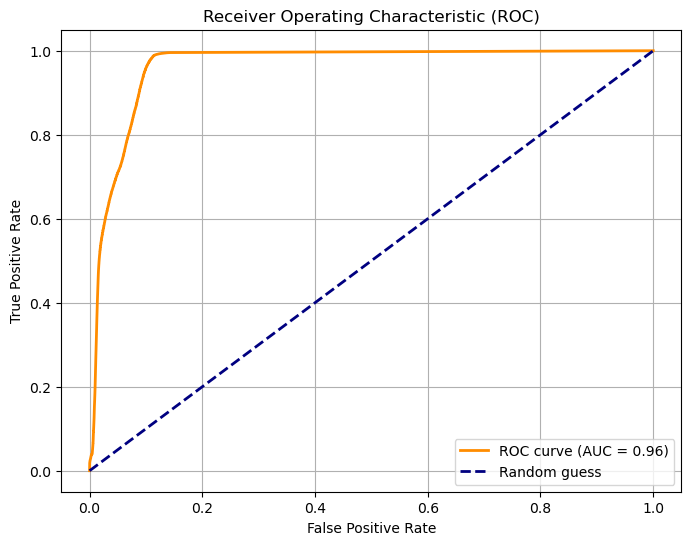

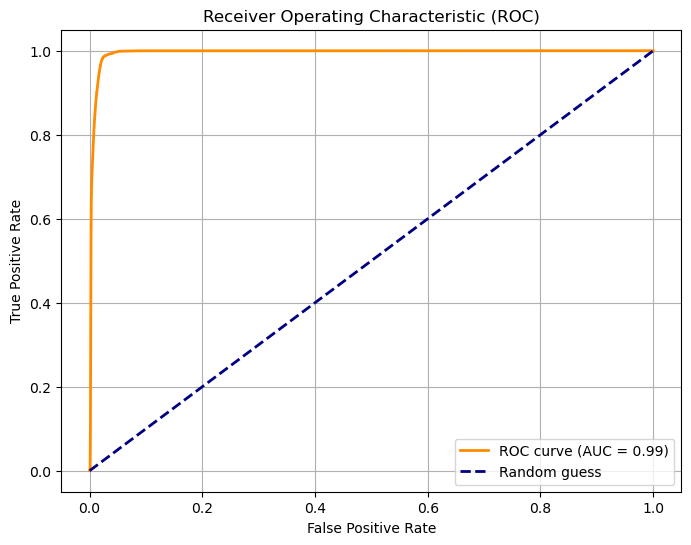

In [136]:
plot_roc_curve(pos_list[0],myMaskImgs[0])
plot_roc_curve(pos_list[1],myMaskImgs[1])

Question: We should really be using three separate sets of files: a training set, a validation set, and a test set! Explain why.

Answer:The purpose of using training, validation, and test sets is different. Training set make sure there is enough data to train the model. Validation set make sure there is reliable feedback when adjusting hyperparameters,which is the tuning part. Test set make sure there is an objective standard for the final evaluation of the model. 

Validation set participates in the training process. It is like a extension of training set but the groundtruth is not used to train model,it help us to judge if the model is overfitted of something. After model training and tuning are completed, it is time for test set to evaluate the final performance of the model. In this process the test set mast be datas that the model never seem before so the evaluation result can be reliable.
